# Autoencoder: Sub-Module of the EEG-GAN Package

The autoencdoer code we are using today is part of our larger package, [EEG-GAN](https://autoresearch.github.io/EEG-GAN/). This package uses generative modelling - specifically, generative adversarial networks - to increase sample sizes by creating synthetic participants. We have shown that doing this enhances classification performance by providing more training samples for classification models. You can read more about this in our [published manuscript](https://escholarship.org/uc/item/9gz8g908). This package may actually be useful here with this data for this challenge; however, it has not been tested using SEEG data nor with so many conditions (i.e., up to 30 video clips) and with so little samples, so we opted not to present this package here. 

With that said, we are actively developing EEG-GAN v2.0, and this future version will contain an embedded autoencoder, which is the code included within this repo. Although this package is in active development, the autoencoder component is stabilized and thoroughly tested to work. 

# Import Modules

In [91]:
import os
import pandas as pd
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
import scipy
import matplotlib.pyplot as plt

import scipy.signal as ss
import scipy.stats as sst

import torch
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present
from nn_architecture.ae_networks import TransformerAutoencoder, TransformerDoubleAutoencoder, TransformerFlattenAutoencoder
from helpers.dataloader import Dataloader

pd.set_option('display.max_columns', 5)

# Setup Functions

In [80]:
def notch_data(samples, fs=1024, notch_freq=60.0, quality_factor=20.0, data_prefix='Time'):
    
    #Determine columns containing neural data
    neural_indices = [column_index for column_index, column_name in enumerate(samples.columns) if data_prefix in column_name]

    b_notch, a_notch = ss.iirnotch(notch_freq, quality_factor, fs)
    filtered_signal = ss.filtfilt(b_notch, a_notch, samples.iloc[:, neural_indices[0]:], axis=1)
    samples.iloc[:, neural_indices[0]:] = filtered_signal
    
    return samples

def filter_data(samples, lowcut=0.1, highcut=200, fs=1024, order=5, padding=3, data_prefix='Time'):
    '''
    ...add here
    '''
    padding_datapoints = padding*fs
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = ss.butter(order, [low, high], btype='bandpass')
    
    #Determine columns containing neural data
    neural_indices = [column_index for column_index, column_name in enumerate(samples.columns) if data_prefix in column_name]

    #Filter signal
    filtered_signal = ss.filtfilt(b, a, samples.iloc[:, neural_indices[0]:], padlen=(padding*fs), axis=1)
    samples.iloc[:, neural_indices[0]:] = filtered_signal
    
    return samples

def artifact_rejection(samples, threshold=5, data_prefix='Time'):

    #Determine columns containing neural data
    neural_indices = [column_index for column_index, column_name in enumerate(samples.columns) if data_prefix in column_name]

    #Determine gradients and z-scores
    grad = np.gradient(samples.iloc[:, neural_indices[0]:], axis=1)
    g_zs = sst.zscore(grad, axis=1)
    h_zs = sst.zscore(samples.iloc[:, neural_indices[0]:], axis=1)
    
    #Determine which segments should be removed
    reject = np.logical_or(np.abs(g_zs) > threshold, np.abs(h_zs) > threshold) #Determine all datapoints that violate criteria
    reject = np.any(reject, axis=1)
    
    #Convert to which segments should be kept
    keep = [not r for r in reject]
    
    #Report
    print(f"{np.sum(reject)} of {len(samples)} ({np.round((np.sum(reject)/len(samples))*100)}%) of segments were rejected.")
    
    return samples.loc[keep]

def downsample_data(samples, sampling_rate=1024, downsampled_rate=256, data_prefix='Time'):

    #Determine columns containing neural data
    neural_indices = [column_index for column_index, column_name in enumerate(samples.columns) if data_prefix in column_name]

    #Determine length of samples in seconds
    number_of_seconds = samples.iloc[0][neural_indices[0]:].shape[0]/sampling_rate
    
    #Determine number of datapoints after downsampling
    new_number_of_datapoints = int(number_of_seconds*downsampled_rate)
    
    #Determine new column names
    sr_ratio = sampling_rate/downsampled_rate
    metadata_names = samples.columns[:neural_indices[0]]
    downsampled_time_names = [column_name for column_index, column_name in enumerate(samples.columns[neural_indices[0]:]) if column_index%sr_ratio == 0]
    downsampled_names = list(metadata_names) + list(downsampled_time_names)
    
    #Iterate through samples to downsample
    downsampled_samples = pd.DataFrame(columns=downsampled_names)
    for sample_index in range(len(samples)):
        current_sample = samples.iloc[sample_index]
        current_metadata = current_sample.iloc[:neural_indices[0]]
        current_sample = current_sample.iloc[neural_indices[0]:]
        downsampled_sample = scipy.signal.resample(current_sample, new_number_of_datapoints)
        new_sample = pd.DataFrame([list(current_metadata) + list(downsampled_sample)], columns=downsampled_names)
        downsampled_samples = pd.concat([downsampled_samples, new_sample])

    return downsampled_samples       

def initiate_autoencoder(ae_dict, dataset):

    n_channels = dataset.shape[-1]
    sequence_length = dataset.shape[1] - dataloader.labels.shape[1]

    if ae_dict['configuration']['target'] == 'channels':
        autoencoder = TransformerAutoencoder(input_dim=n_channels,
                                       output_dim=ae_dict['configuration']['channels_out'],
                                       output_dim_2=sequence_length,
                                       target=TransformerAutoencoder.TARGET_CHANNELS,
                                       hidden_dim=ae_dict['configuration']['hidden_dim'],
                                       num_layers=ae_dict['configuration']['num_layers'],
                                       num_heads=ae_dict['configuration']['num_heads'],).to('cpu')
    elif ae_dict['configuration']['target'] == 'time':
        autoencoder = TransformerAutoencoder(input_dim=sequence_length,
                                       output_dim=ae_dict['configuration']['timeseries_out'],
                                       output_dim_2=n_channels,
                                       target=TransformerAutoencoder.TARGET_TIMESERIES,
                                       hidden_dim=ae_dict['configuration']['hidden_dim'],
                                       num_layers=ae_dict['configuration']['num_layers'],
                                       num_heads=ae_dict['configuration']['num_heads'],).to('cpu')
    elif ae_dict['configuration']['target'] == 'full':
        autoencoder = TransformerDoubleAutoencoder(input_dim=n_channels,
                                             output_dim=ae_dict['configuration']['output_dim'],
                                             output_dim_2=ae_dict['configuration']['output_dim_2'],
                                             sequence_length=sequence_length,
                                             hidden_dim=ae_dict['configuration']['hidden_dim'],
                                             num_layers=ae_dict['configuration']['num_layers'],
                                             num_heads=ae_dict['configuration']['num_heads'],).to('cpu')
    else:
        raise ValueError(f"Encode target '{ae_dict['configuration']['target']}' not recognized, options are 'channels', 'time', or 'full'.")
    consume_prefix_in_state_dict_if_present(ae_dict['model'],'module.')
    autoencoder.load_state_dict(ae_dict['model'])
    autoencoder.device = torch.device('cpu')

    return autoencoder

# Loading and Re-Organizing the Data

The autoencoder needs a very specific data structure to work. The csv files provided for each participant is already in this data stucture, so we will not have to do too much data manipulation in this workshop, which is great.

We use a very simple 2-dimensional data structure where each row is a different trial-level sample for one condition and one electrode. We will direct the autoencoder with column names to guide it in understanding what is metadata and what is neural data. For example, below we will inform the autoencoder that the electrode labels are within the `Electrode` column (i.e., `channel_label=Electrode`) and that the neural data begins with the prefix `Time` (i.e., `kw_timestep=Time`). Behind the scenes, the autoencoder will use the electrode labels to transform the data from a 2D matrix to a 3D matrix and will only include data with the given prefix as the neural data. The autoencoder will ignore any other columns not specified. For example, when looking at the data snippet below, it will ignore the columns `ParticipantID`, `Phase`, and `Condition` because it does not need this information.

| participant_id | Phase | Condition | Electrode | Time0000 | Time0001 | Time0002 | Time0003 | ... |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| e0010GP | Encoding | 1 | HIP1 | 2.28 | -4.44 | -0.98 | -5.67 | ... |
| e0010GP | Encoding | 1 | HIP2 | 11.67 | 0.66 | 1.43 | 11.62 | ... |
| e0010GP | Encoding | 2 | HIP1 | 11.90 | 8.67 | 1.85 | 0.73 | ... |
| e0010GP | Encoding | 2 | HIP2 | 6.73 | 3.63 | 3.80 | 5.63 | ... |
| ... | ... | ... | ... | ... | ... | ... | ... |

## Loading Data

In this workshop, we will be looking through participant data multiple times. Instead of re-loading each dataset over and over again, we might as well load them all once and keep them stored in a variable. We will do this by creating a dictionary where each key is a different participant's dataframe. 

In [72]:
#First, we designate where the data is
data_path = os.path.abspath('/oscar/data/brainstorm-ws/seeg_data/Memory Task Data/Epilepsy/Monitoring/')

#We will also manually set which participants to include in the autoencoder training
participant_files = [
              f'{data_path}/e0010GP_data.csv',
              f'{data_path}/e0011XQ_data.csv',
              f'{data_path}/e0013LW_data.csv',
              #f'{data_path}/e0015TJ_data.csv', #TODO: ADD THIS BACK, JUST PROCESSING NOW
              #f'{data_path}/e0017MC_data.csv', #Does not have any electrodes with the HIP naming convention
              #f'{data_path}/e0019VQ_data.csv', #TODO: ADD THIS BACK, JUST PROCESSING NOW
              f'{data_path}/e0020JA_data.csv',
              #f'{data_path}/e0024DV_data.csv' #TODO: ADD THIS BACK, JUST PROCESSING NOW
              ]

#We will determine all participant ids 
participant_ids = [participant_file.split('/')[-1].replace('_data.csv','') for participant_file in participant_files]

#Now, let's load all participant data and save them into a dictionary
participant_data = {} #Create empty dictionary
for participant_index, participant_file in enumerate(tqdm(participant_files)):
    participant_data[participant_ids[participant_index]] = pd.read_csv(participant_file, dtype = {'Electrode': str})
                                                                       
#We can report what we created
print(f"Dictionary Keys: {participant_data.keys()}\n")
print('Example dataset:')
print(participant_data[list(participant_data.keys())[0]])

100%|██████████| 4/4 [01:29<00:00, 22.39s/it]

Dictionary Keys: dict_keys(['e0010GP', 'e0011XQ', 'e0013LW', 'e0020JA'])

Example dataset:
     Participant_ID          Phase  ...    Time5118   Time5119
0           e0010GP       Encoding  ...   75.100557  36.021683
1           e0010GP       Encoding  ...    1.462135  -1.462135
2           e0010GP       Encoding  ...  -42.401907 -51.706401
3           e0010GP       Encoding  ...  101.684825  95.038758
4           e0010GP       Encoding  ...  -64.466850 -65.264378
...             ...            ...  ...         ...        ...
7585        e0010GP  NextDayRecall  ...    0.664607 -17.944381
7586        e0010GP  NextDayRecall  ...   42.933593  39.211795
7587        e0010GP  NextDayRecall  ...  -36.021683 -11.298314
7588        e0010GP  NextDayRecall  ...   19.273594   5.715618
7589        e0010GP  NextDayRecall  ...   32.565728  21.134493

[7590 rows x 5126 columns]


## Electrodes
One other requirement that the autoencoder has is that every participant has the same number of electrodes. This toolbox was designed for EEG analyses, and this is the standard practice in that research---but as we have seen throughout this week, our participants have both a different number of electrodes and electrodes in different locations. What this means is that we are going to have to make some decisions on how many electrodes, and which electrodes, to include for each participant.

Later on, we are going to use an adapted version of Younes Strittmatter's classification notebook, which focuses on hippocampus electrodes (i.e., uses electrodes with the `HIP` acronym), so here we will only focus on these electrodes. Let's cycle through each participant and see which hippocampus electrodes they have.

In [73]:
#Determine the brain region of interest
brain_region = 'HIP'

#Iterate through all participants
for participant_id in participant_data.keys():
    print(f"Participant: {participant_id}") #Report which participant
    electrodes = [electrode.split('_')[-1] for electrode in participant_data[participant_id]['Electrode'].unique() if brain_region.lower() in electrode.lower()] #Determine corresponding electrodes
    print(f"Electrodes ({len(electrodes)}):\n{electrodes}\n") #Report found electrodes

Participant: e0010GP
Electrodes (24):
['PHIP1', 'PHIP10', 'PHIP11', 'PHIP12', 'PHIP2', 'PHIP3', 'PHIP4', 'PHIP5', 'PHIP6', 'PHIP7', 'PHIP8', 'PHIP9', 'MHIP1', 'MHIP10', 'MHIP11', 'MHIP12', 'MHIP2', 'MHIP3', 'MHIP4', 'MHIP5', 'MHIP6', 'MHIP7', 'MHIP8', 'MHIP9']

Participant: e0011XQ
Electrodes (24):
['HIPB1', 'HIPB10', 'HIPB2', 'HIPB3', 'HIPB4', 'HIPB5', 'HIPB6', 'HIPB7', 'HIPB8', 'HIPB9', 'HIPH1', 'HIPH10', 'HIPH11', 'HIPH12', 'HIPH2', 'HIPH3', 'HIPH4', 'HIPH5', 'HIPH6', 'HIPH7', 'HIPH8', 'HIPH9', 'HIPB11', 'HIPH13']

Participant: e0013LW
Electrodes (13):
['Ahip1', 'Ahip10', 'Ahip11', 'Ahip12', 'Ahip13', 'Ahip2', 'Ahip3', 'Ahip4', 'Ahip5', 'Ahip6', 'Ahip7', 'Ahip8', 'Ahip9']

Participant: e0020JA
Electrodes (176):
['LHIPBD1', 'LHIPBD10', 'LHIPBD11', 'LHIPBD12', 'LHIPBD13', 'LHIPBD14', 'LHIPBD2', 'LHIPBD3', 'LHIPBD4', 'LHIPBD5', 'LHIPBD6', 'LHIPBD7', 'LHIPBD8', 'LHIPBD9', 'LHIPHD1', 'LHIPHD10', 'LHIPHD11', 'LHIPHD12', 'LHIPHD13', 'LHIPHD14', 'LHIPHD2', 'LHIPHD3', 'LHIPHD4', 'LHIPHD5', '

You will notice that the participants have quite different electrodes within the hippocamps. This could mean that participants have electrodes in different locations but in some cases it could also simply indicate that there are different naming conventions per participant. Ideally, we would be able to find a number of electrodes that are completely consistent across participants but this may not be possible with the current dataset due to the nature of collecting SEEG data. 

So, instead of selecting common electrodes, we will randomly select a set of electrodes for each participant and hope that they are similar enough to consider consistent across participants. The classification code that Younes presented has us averaging across these electrodes anyhow, so this seems like a safe enough process here. 

The participants also have a different number of electrodes within the hippocampus, ranging from 13 to 176. As the autoencoder needs the same number of electrodes for each participant, we need to select a number of electrodes equal to or less than the lower end of this range. In other words, we'll need to select up to 13 electrodes per participant. I personally prefer even numbers, so let's choose 12 electrodes per participant. 

You could select which electrodes to include manually if you would like, but instead here we will randomly select 12 of the hippocampus electrodes per participant. We will set a seed in our `numpy` random function first so that we end up with the same 12 electrodes per participant every time we run this code. 

In [81]:
#Set numpy seed
np.random.seed(42)

#Determine the brain region of interest
brain_region = 'HIP'
number_of_electrodes = 12

#Iterate through each participant and collect 12 electrodes per participant 
selected_electrodes = {} #Setup a variable to collect the selected electrodes
for participant_id in participant_data.keys():
    electrodes = [electrode for electrode in participant_data[participant_id]['Electrode'].unique() if brain_region.lower() in electrode.lower()] #Determine corresponding electrodes
    electrodes = np.random.choice(electrodes, number_of_electrodes, replace=False) #Randomly select a number of electrodes equal to the variable number_of_electrodes
    selected_electrodes[participant_id] = electrodes #Save selected electrodes as a list of lists to use later
    
#Print as dataframe
pd.set_option('display.max_columns', len(participant_files)) #Show more columns just for a moment
print(pd.DataFrame(np.array([selected_electrodes[key] for key in selected_electrodes.keys()]).T, columns = [participant_file.split('/')[-1].replace('_data.csv','') for participant_file in participant_files]))
pd.set_option('display.max_columns', 5) #Reset to showing 5 columns max

   e0010GP e0011XQ e0013LW              e0020JA
0    PHIP6   HIPB5   Ahip1   14_e0020JA_LHIPHD6
1    MHIP2   HIPH6   Ahip2   14_e0020JA_LHIPBD2
2    PHIP1  HIPB10  Ahip11  15_e0020JA_RHIPHD15
3    MHIP4   HIPB7   Ahip3   14_e0020JA_RHIPBD9
4    PHIP9   HIPB1  Ahip12  15_e0020JA_LHIPHD13
5    PHIP7   HIPH1   Ahip4   15_e0020JA_RPHIPP8
6   MHIP10  HIPH11  Ahip13   14_e0020JA_LHIPHD2
7   PHIP10   HIPH7   Ahip7  15_e0020JA_RHIPHD13
8    MHIP7   HIPB4   Ahip9   14_e0020JA_LHIPBD5
9    PHIP3   HIPH8   Ahip6   15_e0020JA_LHIPHD7
10  PHIP11   HIPB8  Ahip10  14_e0020JA_RHIPBD11
11   MHIP1   HIPB3   Ahip8   14_e0020JA_LHIPHD3


## Combining Data Files

Another requirement the autoencoder has is that all of the data is within the same csv file. Above we have created a list of participants to include and we have determined which electrodes to use per participant, so now we will extract the participant data for each participant and add it all to a single dataframe and then save this dataframe in our current repo's `data` sub-directory. 

The autoencoder should only be trained with the data that you will use to train your classification model. In the classification code, we will train our model on the `Encoding` and `SameDayRecall` phases and test it's performance on the `NextDayRecall` phase. As such, we will only include the `Encoding` and `SameDayRecall` phases in our new datafile.

Furthermore, the autoencoder model can get quite big with large datasets, and having 5 seconds at 1024Hz (i.e., 5120 datapoints) is quite large. Large data and models may fail if they fill your memory. So, we will here condense the data in two ways. First, we are going to trim the data using the `cut_data` function below. In this workshop, we will cut the data to 3 seconds by removing the last 2 seconds. Second, we will downsample the data using the `downsample_data` function below. In this workshop we will reduce the sampling rate from 1024Hz to 256Hz. Together this means our sample will be reduced from 5120 datapoints to 768 datapoints, or in other words we will reduce the dataset size by 85%.


WARNING: Sharp wave ripples (SWR) are in the 110 - 200Hz range and the frequencies you can extract from data equal half of the sampling rate (this is called the Nyquist Limit). So, if we downsample to 256Hz, we can only extract frequencies up to 128Hz, cutting out the majority of these SWR frequencies. If we want to keep these SWR frequencies, it would be better to downsample to 512Hz, which would allow us to extract frequencies up to 256Hz.

In [83]:
#We will first create a dataframe to store all of our participant data in
times = [f"Time{str(datapoint).zfill(4)}" for datapoint in range(5120)]
ae_data = pd.DataFrame(columns=['Participant_ID','Phase','Condition','Electrode','Error_Position','Error_Color']+times)

#We will indicate which phases we are going to include in the training file
training_phases = ['Encoding', 'SameDayRecall']

#Iterate through each participant, filtering the data to the specified phases and electrodes, and store it into the master variable
for participant_id in tqdm(participant_data.keys()):
    phase_indices = participant_data[participant_id]['Phase'].isin(training_phases) #Phase indices
    electrode_indices = participant_data[participant_id]['Electrode'].isin(selected_electrodes[participant_id]) #Electrode indices
    p_data = participant_data[participant_id][(phase_indices) & (electrode_indices)] #Extract participant data

    #We also need to rename all of the electrodes so that there is consistency of electrode labels across participants
    for electrode_index, selected_electrode in enumerate(selected_electrodes[participant_id]):
        p_data = p_data.replace({selected_electrode: electrode_index+1})
        
    #Pre-Process Data
    p_data = notch_data(p_data, fs=1024, notch_freq=60.0, quality_factor=20.0, data_prefix='Time')
    p_data = filter_data(p_data, lowcut=0.1, highcut=120, fs=1024, order=5, padding=3, data_prefix='Time') #Note: You should really only filter the continuous data, and not segmented data like we are doing here because the latter will introduct 'edge artifacts'
    p_data = artifact_rejection(p_data, threshold=5, data_prefix='Time')
    p_data = downsample_data(p_data, sampling_rate=1024, downsampled_rate=256, data_prefix='Time')

    #Add data to the master variable
    ae_data = pd.concat([ae_data, p_data])
    
#Save data to csv
ae_data.to_csv('data/seeg_ae_training_data.csv', index=False)

  0%|          | 0/4 [00:00<?, ?it/s]

0 of 540 (0.0%) of segments were rejected.


 25%|██▌       | 1/4 [00:06<00:20,  6.99s/it]

0 of 1080 (0.0%) of segments were rejected.


 50%|█████     | 2/4 [00:23<00:25, 12.54s/it]

0 of 2160 (0.0%) of segments were rejected.


 75%|███████▌  | 3/4 [00:59<00:23, 23.43s/it]

0 of 420 (0.0%) of segments were rejected.


100%|██████████| 4/4 [01:13<00:00, 18.30s/it]


We can see the file is now within our directory. As this file is now ready and in our directory, we are ready to train the autoencoder!

In [77]:
!dir data

ganTrialElectrodeERP_p50_e8_len100.csv	seeg_ae_training_data.csv


# Autoencoder

The autoencoder is designed to be used within the command line interface (CLI). What this means is that we do not use functions, such as `train_autoencoder(training_data)` as is common with Python. Insteead we are going to run commands such as `python autoencoder_training_main.py ...` where `...` are our input parameters. If you are not familiar with CLI programming, not to worry as we will show you how to do so here. 

In jupyter notebooks, if you begin a line of code with `!` it will run via the CLI. Our Autoencoder has a `help` parameter so let's see how that works here:

In [78]:
!python autoencoder_training_main.py help


-----------------------------------------
Command line arguments:
-----------------------------------------



----------------------------------------------------------------------------------------------------------------------------------------------------
INPUT HELP - These are the inputs that can be given from the command line
----------------------------------------------------------------------------------------------------------------------------------------------------


Input           | Type            | Description                                                                                   | Default value               
----------------------------------------------------------------------------------------------------------------------------------------------------
ddp             | <class 'bool'>  | Activate distributed training                                                                 | False                       
load_checkpoint | <class 'bool'>  | Load a 

## Parameters

The help menu above provides a full list of adjustable parameters, but most often only a handfull of these parameters are going to be tweaked, so let's outline these here.

`path_dataset`: This is the path to our dataset<br>
`save_name`: Path to save the file to (note, this seems not to function on Oscar for some reason)<br><br>

`kw_timestep`: The column name prefix of your neural data<br>
`channel_label`: The column name of your electrode labels<br><br>

`target`: The dimension to encode data, we can encode the timeseries (`time`), the electrodes (`channel`), or both (`full`)<br>
`timeseries_out`: The encoded size for electrodes. Only applies if `target` equals `channel` or `full`<br>
`channels_out`: The encoded size for electrodes. Only applies if `target` equals `channel` or `full`<br><br>

`n_epochs`: The number of epochs to train the autoencoder<br>
`ddp`: Whether to activate distributed data parallel training. This means that training will occurs across all GPUs. This does not directly quicken training but makes it more efficient, thus needing less epochs for the same results 

# Autoencoder (Sample Data)

We will train an autoencoder on the SEEG data momentarily, but for a quick proof of concept let's apply it to our sample data (`ganTrialElectrodeERP_p50_e8_len100.csv`).

This data contains `8 electrodes` and `100 datapoints`. The data actually spans 1200ms and was originally recorded at `512Hz` but we have downsampled it to 100 datapoints, which gives it an effect sampling rate of `~83Hz`.

Here, we will use the autoencoder to reduce both the electrode and time dimension in half. This means that we will have reduced the data to `1/4` of it's size.<br>
`Time`: 100 datapoints -> 50 datapoints<br>
`Electrodes`: 8 electrodes -> 4 electrodes<br>

We will train for 100 epochs just to quicken the process or else it would take too long to run in this workshop. We will also use ddp training here.<br>

Let's define these parameters now:

In [94]:
path_dataset = 'data/ganTrialElectrodeERP_p50_e8_len100.csv'
save_name = 'trained_ae/sample_data_autoencoder.pt'

kw_timestep = 'Time'
channel_label = 'Electrode'

target = 'full'
timeseries_out = 50
channels_out = 4

n_epochs = 500

Now that we have defined our parameters, we can run the training code via the command line interface by starting our command with `!`. Note that the following script has the ddp parameter in it. If you do not have GPUs this will crash. Just delete this parameter and you can train on CPUs.

In [ ]:
!python autoencoder_training_main.py ddp path_dataset={path_dataset} save_name={save_name} target={target} kw_timestep={kw_timestep} channel_label={channel_label} channels_out={channels_out} timeseries_out={timeseries_out} n_epochs={n_epochs}


-----------------------------------------
Command line arguments:
-----------------------------------------

Distributed training is active
Dataset: data/ganTrialElectrodeERP_p50_e8_len100.csv
Model save name: trained_ae/sample_data_autoencoder.pt
Target: full
Keyword for the time step of the dataset: Time
Channel label: Electrode
Encoded channels size: 4
Encoded time series size: 50
Number of epochs: 500
-----------------------------------------

Using device cuda:2.
Using device cuda:1.
Using device cuda:0.
Using device cuda:3.
 26%|▎| 128/500 [07:36<21:59,  3.55s/it, TRAIN LOSS: 0.000756, TEST LOSS: 0.0005

You can see the new autoencoder saved into the `trained_ae` folder. Again, the `save_name` parameter should have saved the autoencoder with the name specified, but for some reason this does not work on Oscar.

In [89]:
!dir trained_ae

ae_ddp_100000ep_20240114_105836.pt  ae_ddp_5000ep_20240114_095539.pt
ae_ddp_10000ep_20240114_112303.pt   ae_ddp_5000ep_20240114_102812.pt
ae_ddp_1000ep_20240114_093740.pt    ae_ddp_5000ep_20240114_103944.pt
ae_ddp_1000ep_20240114_094547.pt    ae_ddp_5000ep_20240114_115748.pt
ae_ddp_1000ep_20240114_110331.pt    ae_seeg.pt
ae_ddp_100ep_20240118_002244.pt     checkpoint.pt
ae_ddp_100ep_20240118_120509.pt     fully_trained_ae_seeg.pt
ae_ddp_2ep_20240114_003446.pt	    test_ae.pt
ae_ddp_2ep_20240114_003522.pt


# Evaluating the Autoencoder (Sample Data)

Now that the autoencoder is trained, it's important to see if it worked. We can do this by loading data, and running that data through the autoencoder and see how closely the original data and the autoencoder-reconstructed data match. 

First, let's load the autoencoder and view the configuration of the autoencoder.

In [92]:
#Determine paths to data and autoencoder
ae_checkpoint = 'trained_ae/ae_ddp_100ep_20240118_120509.pt'

#Load the autoencoder
ae_dict = torch.load(ae_checkpoint, map_location=torch.device('cpu'))

#Report
for key in ae_dict['configuration'].keys():
    if key != 'dataloader' and key != 'history':
        print(f"{key}: {ae_dict['configuration'][key]}")

device: cuda
model_class: TransformerDoubleAutoencoder
batch_size: 128
n_epochs: 100
sample_interval: 100
learning_rate: 0.0001
hidden_dim: 256
path_dataset: data/ganTrialElectrodeERP_p50_e8_len100.csv
path_checkpoint: trained_ae/checkpoint.pt
timeseries_out: 50
channels_out: 4
target: full
channel_label: Electrode
trained_epochs: 100
input_dim: 8
output_dim: 4
output_dim_2: 50
num_layers: 2
num_heads: 8
activation: sigmoid


Now, we can load the data and see how well the autoencoder can reconstruct the data after reducing it to the given dimensions.

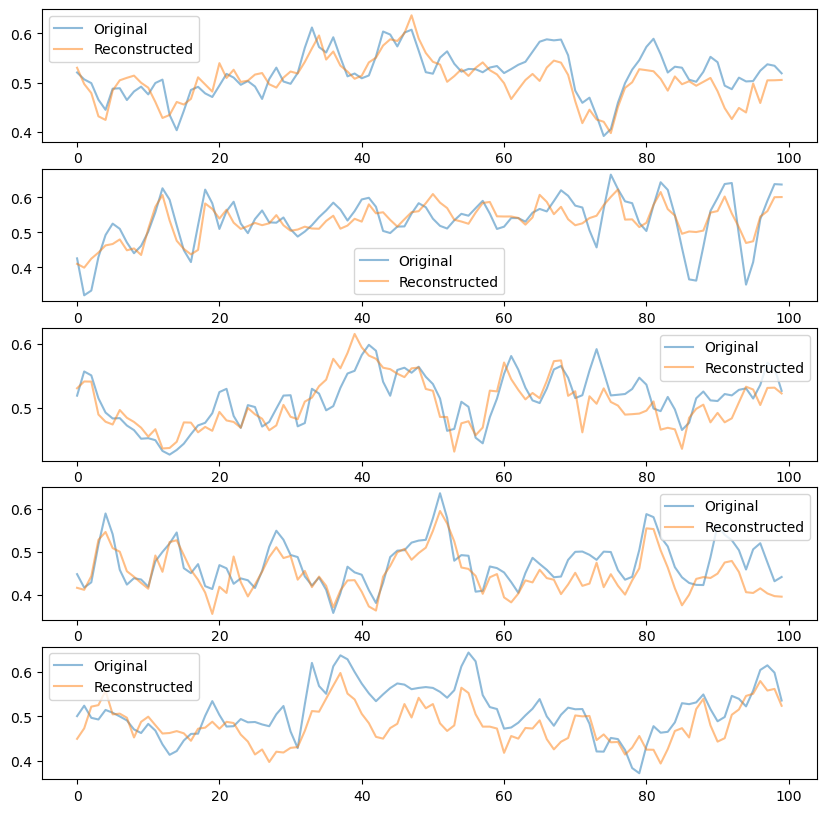

In [93]:
#Load and normalize the data to be within [0,1] (as the autoencoder uses normalized data)
data_checkpoint = 'data/ganTrialElectrodeERP_p50_e8_len100.csv'
dataloader = Dataloader(data_checkpoint, col_label='Condition', channel_label='Electrode')
dataset = dataloader.get_data()
def norm(data):
    return (data-np.min(data)) / (np.max(data) - np.min(data))
dataset = norm(dataset.detach().numpy())

#Initiate autoencoder
autoencoder = initiate_autoencoder(ae_dict, dataset)

#Plot 5 random samples to see reconstruction
plt.rcParams['figure.figsize'] = [10, 10] #Set figure size
fig, axs = plt.subplots(5,1) #Create figure
for i in range(5):
    sample = np.random.choice(len(dataset), 1) #Randomly determine which sample to plot
    data = dataset[sample,1:,:] #Retrieve the sample to plot
    axs[i].plot(data[0,:,0], alpha=.5, label='Original') #Plot data
    axs[i].plot(autoencoder.decode(autoencoder.encode(torch.from_numpy(data)))[0,:,0].detach().numpy(), alpha=.5, label='Reconstructed') #Plot reconstructed data
    axs[i].legend() #Plot legend
plt.show() #Show plot

# Autoencoder (SEEG Data)

Now let's train the autoencoder on the SEEG data that we created at the beginning of this workshop (`seeg_ae_training_data.csv`).

This data contains the `12 electrodes` that we chose. Furthermore, we downsampled the data from `1024Hz` to `256Hz`, and contains 5 seconds of data, so we have `256*5 = 1280` datapoints.

Here, we will use the autoencoder to reduce both the electrode and time dimension in half. This means that we will have reduced the data to `1/4` of it's size.<br>
`Time`: 1280 datapoints -> 640 datapoints<br>
`Electrodes`: 12 electrodes -> 6 electrodes<br>

We will train for 100 epochs just to quicken the process or else it would take too long to run in this workshop. We will also use ddp training here.<br>

Let's define these parameters now:

In [ ]:
path_dataset = 'data/seeg_ae_training_data.csv'
save_name = 'trained_ae/seeg_autoencoder.pt'

kw_timestep = 'Time'
channel_label = 'Electrode'

target = 'full'
timeseries_out = 640
channels_out = 6

n_epochs = 100

In [ ]:
!python autoencoder_training_main.py ddp path_dataset={path_dataset} save_name={save_name} target={target} kw_timestep={kw_timestep} channel_label={channel_label} channels_out={channels_out} timeseries_out={timeseries_out} n_epochs={n_epochs}

# Evaluating the Autoencoder (SEEG Data)

Now that the autoencoder is trained, it's important to see if it worked. We can do this by loading data, and running that data through the autoencoder and see how closely the original data and the autoencoder-reconstructed data match. 

First, let's load the autoencoder and view the configuration of the autoencoder.

In [ ]:
#Determine paths to data and autoencoder
ae_checkpoint = 'trained_ae/ae_ddp_100ep_20240118_120509.pt'

#Load the autoencoder
ae_dict = torch.load(ae_checkpoint, map_location=torch.device('cpu'))

#Report
for key in ae_dict['configuration'].keys():
    if key != 'dataloader' and key != 'history':
        print(f"{key}: {ae_dict['configuration'][key]}")

Now, we can load the data and see how well the autoencoder can reconstruct the data after reducing it to the given dimensions.

In [ ]:
#Load and normalize the data to be within [0,1] (as the autoencoder uses normalized data)
data_checkpoint = 'data/seeg_ae_training_data.csv'
dataloader = Dataloader(data_checkpoint, col_label='Condition', channel_label='Electrode')
dataset = dataloader.get_data()
def norm(data):
    return (data-np.min(data)) / (np.max(data) - np.min(data))
dataset = norm(dataset.detach().numpy())

#Initiate autoencoder
autoencoder = initiate_autoencoder(ae_dict, dataset)

#Plot 5 random samples to see reconstruction
plt.rcParams['figure.figsize'] = [10, 10] #Set figure size
fig, axs = plt.subplots(5,1) #Create figure
for i in range(5):
    sample = np.random.choice(len(dataset), 1) #Randomly determine which sample to plot
    data = dataset[sample,1:,:] #Retrieve the sample to plot
    axs[i].plot(data[0,:,0], alpha=.5, label='Original') #Plot data
    axs[i].plot(autoencoder.decode(autoencoder.encode(torch.from_numpy(data)))[0,:,0].detach().numpy(), alpha=.5, label='Reconstructed') #Plot reconstructed data
    axs[i].legend() #Plot legend
plt.show() #Show plot